# Gaussian Process Distribution of Relaxation Times. 
### Reproduce Figure 7 in the main context

GP-DRT is our newly developed approach that is able to obtain both the DRT mean and covariance from the EIS data by assuming that the DRT is a Gaussian process (GP). It can also predict the DRT and the imaginary part of the impedance at frequencies not previously measured.

The main process for DRT inferring from impedance is that both $\gamma(\xi)$ and $Z^{\rm DRT}_{\rm im}\left(\xi\right)$ are GPs if we assume that $\gamma(\xi)$ is a GP considering that GP is closed for linear tranformation. Hence,

$\begin{pmatrix}
\gamma(\xi) \\
Z^{\rm DRT}_{\rm im}\left(\xi\right)
\end{pmatrix}\sim \mathcal{GP}\left(\mathbf 0, \begin{pmatrix}
k(\xi, \xi^\prime) & \mathcal L^{\rm im}_{\xi^\prime} \left(k(\xi, \xi^\prime)\right)\\
\mathcal L^{\rm im}_{\xi} k(\xi, \xi^\prime) & \mathcal L^{\rm im}_{\xi^\prime}\left(\mathcal L^{\rm im}_{\xi} \left(k(\xi, \xi^\prime)\right)\right)
\end{pmatrix}\right)$

where

$\mathcal L^{\rm im}_\xi \left(\cdot\right) = -\displaystyle \int_{-\infty}^\infty \frac{2\pi \displaystyle e^{\xi-\hat \xi}}{1+\left(2\pi \displaystyle e^{\xi-\hat \xi}\right)^2}  \left(\cdot\right) d \hat \xi$ 

is a linear functional to transform DRT to imaginary part of impedance.

For more than one observation, $\left(\mathbf Z^{\rm exp}_{\rm im}\right)_n = Z^{\rm exp}_{\rm im}(\xi_n)$ with $\xi_n =\log f_n$ and $n =1, 2, \ldots N $, the corresponding multivariate Gaussian RV is written as 

$\begin{pmatrix}
\boldsymbol{\mathbf{\gamma}} \\
\mathbf Z^{\rm exp}_{\rm im}
\end{pmatrix}\sim \mathcal{N}\left(\mathbf 0, \begin{pmatrix}
\mathbf K & \mathcal L_{\rm im} \mathbf K\\
\mathcal L_{\rm im}^\sharp \mathbf K & \mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I
\end{pmatrix}\right)$

where 

$\begin{align}
(\mathbf K)_{nm} &= k(\xi_n, \xi_m)\\
(\mathcal L_{\rm im} \mathbf K)_{nm} &= \left. \mathcal L^{\rm im}_{\xi^\prime} \left(k(\xi, \xi^\prime)\right) \right |_{\xi_n, \xi_m}\\
(\mathcal L_{\rm im}^\sharp \mathbf K)_{nm} &= \left.\mathcal L^{\rm im}_{\xi} \left(k(\xi, \xi^\prime)\right) \right|_{\xi_n, \xi_m}\\
(\mathcal L^2_{\rm im} \mathbf K)_{nm} &= \left.\mathcal L^{\rm im}_{\xi^\prime}\left(\mathcal L^{\rm im}_{\xi} \left(k(\xi, \xi^\prime)\right)\right) \right|_{\xi_n, \xi_m}
\end{align}$

To obtian the DRT from impedance, the distribution of $\mathbf{\gamma}$ conditioned on $\mathbf Z^{\rm exp}_{\rm im}$ can be written as

$\mathbf{\gamma}|\mathbf Z^{\rm exp}_{\rm im}\sim \mathcal N\left( \mathbf \mu_{\gamma|Z^{\rm exp}_{\rm im}}, \mathbf\Sigma_{\gamma| Z^{\rm exp}_{\rm im}}\right)$

with

$\begin{align}
\mathbf \mu_{\gamma|Z^{\rm exp}_{\rm im}} &= \mathcal L_{\rm im} \mathbf K \left(\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I \right)^{-1} \mathbf Z^{\rm exp}_{\rm im} \\
\mathbf \Sigma_{\gamma| Z^{\rm exp}_{\rm im}} &= \mathbf K- \mathcal L_{\rm im} \mathbf K \left(\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I \right)^{-1}\mathcal L_{\rm im} \mathbf K^\top
\end{align}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
from scipy.optimize import minimize
%matplotlib inline

#### Define parameters for the synthetic impedance based on ZARC model. 

The impedance has the format of $Z^{\rm exact}(f) = R_\infty + \displaystyle \frac{1}{\displaystyle \frac{1}{R_{\rm ct}}+C \left(i 2\pi f\right)^\phi}$, where $\displaystyle C = \frac{\tau_0^\phi}{R_{\rm ct}}$. And the analytical DRT is calculated as $\gamma(\log \tau) =  \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi)\pi\right)}{\displaystyle \cosh(\phi \log(\tau/\tau_0))-\cos(\pi(1-\phi))}$

In [2]:
# define frequency range
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define frequency range used for prediction
freq_vec_star = np.logspace(-4., 4., num=81, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# parameters for ZARC model, the impedance and analytical DRT are calculated as above equations
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.

C = tau_0**phi/R_ct
Z_exact = R_inf+1./(1./R_ct+C*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau/tau_0))-cos((1.-phi)*pi))

# finer mesh for plotting only
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_plot/tau_0))-cos((1.-phi)*pi)) # for plotting only

# random and adding moise to the analytical computed impedance
rng = np.random.seed(214975)
sigma_n_exp = 1.
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

#### show the synthetic impedance in Nyquist plot, as shown in Figure 7 (a)

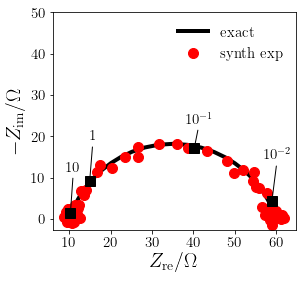

In [9]:
# Nyquist of impedance and label the frequency
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="red", label="synth exp")
plt.plot(np.real(Z_exp[20:60:10]), -np.imag(Z_exp[20:60:10]), 's', markersize=10, color="black")

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-2, 10-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-2, 6-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40]), 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-1, 10-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.show()

#### running the GP-DRT model to get the optimal hyperparameters

In [4]:
# intialize the parameter for global 3D optimization to maximize the marginal log-likelihood as shown in eq (31)
sigma_n = sigma_n_exp
sigma_f = 5.
ell = 1.

theta_0 = np.array([sigma_n, sigma_f, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print(theta[0], theta[1], theta[2])
    
GP_DRT.NMLL_fct(theta_0, Z_exp, xi_vec)
GP_DRT.grad_NMLL_fct(theta_0, Z_exp, xi_vec)
print('sigma_n,           sigma_f,          ell')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_f, ell using the Newton-CG method as implemented in scipy
res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Newton-CG', \
               jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})

sigma_n,           sigma_f,          ell
0.8903599197476706 5.001415082296882 1.0120874912591977
0.8136354402155858 5.003533687387537 1.029191223973519
0.8291862644351911 5.035786747187512 1.2588675436350178
0.8303934003754703 5.083236934181329 1.2117785066002995
0.8304435946349606 5.206077455873398 1.2283658609053703
0.8305174795222053 5.387448882835493 1.2524148478215245
0.8305140530808819 5.406904963014705 1.2546655487001486
0.8305265249777404 5.407074309971135 1.2546848761160714
0.8305262553195482 5.407086124627953 1.2546867263395471
Optimization terminated successfully.
         Current function value: 53.657989
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 89
         Hessian evaluations: 0


In [5]:
# collect the optimized parameters
sigma_n, sigma_f, ell = res.x

# calculate the matrices shown in eq (18)
K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
Sigma = (sigma_n**2)*np.eye(N_freqs)

# the matrix $\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I$ whose inverse is needed
K_im_full = L2_im_K + Sigma

# cholesky factorization, L is lower-triangular matrix
L = np.linalg.cholesky(K_im_full)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# estimate the gamma of eq (21a), the minus sign, which is not included in L_im_K, refers to eq (65)
gamma_fct_est = -np.dot(L_im_K.T, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)
np.diag(np.dot(inv_K_im_full, K_im_full))

# estimate the sigma of gamma for eq (21b)
cov_gamma_fct_est = K - np.dot(L_im_K.T, np.dot(inv_K_im_full, L_im_K))
sigma_gamma_fct_est = np.sqrt(np.diag(cov_gamma_fct_est))

#### plot the DRT together with the analytical DRT

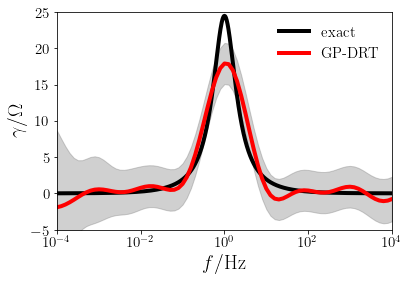

In [6]:
# plot the DRT and its confidence region
plt.semilogx(freq_vec_plot, gamma_fct_plot, linewidth=4, color="black", label="exact")
plt.semilogx(freq_vec, gamma_fct_est, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec, gamma_fct_est-3*sigma_gamma_fct_est, gamma_fct_est+3*sigma_gamma_fct_est, color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

#### calcualte the impedance

In [7]:
# initialize the imaginary part of impedance vector
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

# calculate the imaginary part of impedance at each $\xi$ point for plot
for index, val in enumerate(xi_vec_star):
    xi_star = np.array([val])

    # compute matrices shown in eq (18), k_star corresponds to new point
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star = GP_DRT.matrix_L_im_K(xi_vec, xi_star, sigma_f, ell)
    L2_im_k_star = GP_DRT.matrix_L2_im_K(xi_vec, xi_star, sigma_f, ell)
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # compute Z_im_star mean and standard deviation using eq (26)
    Z_im_vec_star[index] = np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star-np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, L2_im_k_star))
    
    # compute Z_im_star mean and standard deviation
    gamma_vec_star[index] = -np.dot(L_im_k_star.T, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star-np.dot(L_im_k_star.T, np.dot(inv_K_im_full, L_im_k_star))

#### plot the imaginary part of impedance together with the exact one

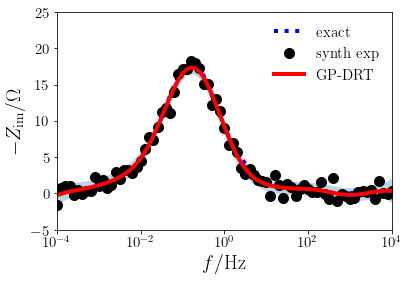

In [8]:
plt.semilogx(freq_vec_star, -np.imag(Z_exact), ":", linewidth=4, color="blue", label="exact")
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()